# IMPORTS

In [5]:
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Bidirectional, LSTM, Dense, Dropout, Attention, Input, Reshape, Permute, Flatten, concatenate
from tensorflow.keras.models import Model
import os
from tqdm import tqdm
import random
import soundfile as sf

# Reproducibility

In [6]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Step 1: Load Data

In [17]:
train_df = pd.read_csv("C:/Users/dell/SHL Hiring Assessment/dataset/train.csv")
test_df = pd.read_csv("C:/Users/dell/SHL Hiring Assessment/dataset/test.csv")

# Step 2: Define Paths

In [18]:
train_audio_path = "C:/Users/dell/SHL Hiring Assessment/dataset/audios_train"
test_audio_path = "C:/Users/dell/SHL Hiring Assessment/dataset/audios_test"

# Step 3: MFCC Feature Extraction

In [9]:
# 🎧 Step 2: Define a function to extract audio features
# Here we extract MFCCs (Mel-frequency cepstral coefficients)
import librosa
import numpy as np

def extract_features(file_path, sr=16000): #sr as parameter for flexibility
    try:
        y, sr_native = librosa.load(file_path, sr=None) #Load with native sr first
        if sr_native != sr:
            y = librosa.resample(y, orig_sr=sr_native, target_sr=sr) #Resample if needed

        duration = librosa.get_duration(y=y, sr=sr)
        rms = np.mean(librosa.feature.rms(y=y))
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        features = np.hstack([duration, rms, zcr, tempo, mfccs, chroma, contrast, tonnetz])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(60)

# Step 4: Safe Wrapper

In [10]:
def safe_process(file_folder, filename):
    file_path = Path(file_folder) / filename
    if file_path.exists():
        return extract_features(str(file_path))
    else:
        print(f"File not found: {file_path}")
        return np.zeros((13,))

# Step 5: Feature Extraction (Train + Test)

In [13]:
from tqdm import tqdm
from pathlib import Path

X_train, X_test, valid_test_filenames = [], [], []

# Train Feature Extraction
for file in tqdm(train_df['filename'], desc="Extracting Train Features"):
    features = safe_process(train_audio_path, file)
    X_train.append(features)

# Test Feature Extraction
for file in tqdm(test_df['filename'], desc="Extracting Test Features"):
    path = Path(test_audio_path) / file
    if path.exists():
        X_test.append(extract_features(str(path)))
    else:
        print(f"Missing test file: {path}")
        X_test.append(np.zeros(60))  # Placeholder
    valid_test_filenames.append(file)
import numpy as np

def fix_length(features, desired_length=60):
    features = np.array(features)
    if len(features) < desired_length:
        return np.pad(features, (0, desired_length - len(features)))
    elif len(features) > desired_length:
        return features[:desired_length]
    return features

# Apply fix to both
X_train = [fix_length(f) for f in X_train]
X_test = [fix_length(f) for f in X_test]

# Convert to numpy
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = train_df['label'].values

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
Extracting Test Features:  25%|█████████████▌                                         | 48/195 [05:32<13:11,  5.38s/it]

Missing test file: C:\Users\dell\SHL Hiring Assessment\dataset\audios_test\audio_177.wav


Extracting Test Features:  37%|████████████████████▌                                  | 73/195 [07:58<09:20,  4.60s/it]

Missing test file: C:\Users\dell\SHL Hiring Assessment\dataset\audios_test\audio_435.wav


Extracting Test Features:  53%|████████████████████████████▌                         | 103/195 [10:12<15:59, 10.43s/it]

Missing test file: C:\Users\dell\SHL Hiring Assessment\dataset\audios_test\audio_300.wav


Extracting Test Features:  59%|███████████████████████████████▊                      | 115/195 [10:55<05:17,  3.97s/it]

Missing test file: C:\Users\dell\SHL Hiring Assessment\dataset\audios_test\audio_521.wav


Extracting Test Features:  62%|█████████████████████████████████▏                    | 120/195 [11:06<03:27,  2.77s/it]

Missing test file: C:\Users\dell\SHL Hiring Assessment\dataset\audios_test\audio_165.wav


Extracting Test Features:  77%|█████████████████████████████████████████▊            | 151/195 [13:19<02:38,  3.59s/it]

Missing test file: C:\Users\dell\SHL Hiring Assessment\dataset\audios_test\audio_519.wav
Missing test file: C:\Users\dell\SHL Hiring Assessment\dataset\audios_test\audio_564.wav


Extracting Test Features:  84%|█████████████████████████████████████████████▍        | 164/195 [14:10<02:14,  4.32s/it]

Missing test file: C:\Users\dell\SHL Hiring Assessment\dataset\audios_test\audio_235.wav


Extracting Test Features:  90%|████████████████████████████████████████████████▍     | 175/195 [15:28<01:49,  5.46s/it]

Missing test file: C:\Users\dell\SHL Hiring Assessment\dataset\audios_test\audio_422.wav


Extracting Test Features: 100%|██████████████████████████████████████████████████████| 195/195 [17:02<00:00,  5.24s/it]


In [9]:
# Debugging: check feature lengths
for i, feat in enumerate(X_test):
    if len(feat) != 60:
        print(f"Test feature at index {i} has length {len(feat)}")

In [10]:
for i, feat in enumerate(X_train):
    if len(feat) != 60:
        print(f"Train feature at index {i} has length {len(feat)}")

In [ ]:
import os
import numpy as np
from pathlib import Path
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Function to process a single file
def process_audio_file(file_path):
    file_path = Path(file_path)
    if file_path.exists():
        return extract_features(str(file_path))
    else:
        print(f"File not found: {file_path}")
        return np.zeros(60)

# Wrapper to enable tqdm with ThreadPoolExecutor
def parallel_process(files, base_path, max_workers=8, desc="Processing"):
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_audio_file, os.path.join(base_path, file)) for file in files]
        for f in tqdm(futures, desc=desc):
            results.append(f.result())
    return np.array(results)

# Run parallel feature extraction
X_train = parallel_process(train_df['filename'], train_audio_path, desc="Extracting Train Features")
X_test = parallel_process(test_df['filename'], test_audio_path, desc="Extracting Test Features")
y_train = train_df['label'].values

# Step 6: Scale the Features

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
#Data scaling and PCA
scaler = RobustScaler() #More robust to outliers than StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Number of PCA components selected: {pca.n_components_}")

# **Random Forest Regressor** 

## An ensemble learning method based on decision trees. It works well with non-linear and noisy data like audio features, and handles overfitting better due to averaging.

## Step 7 : Random Forest with RandomizedSearchCV

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Split for validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)

param_dist = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [None, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_tr, y_tr)
best_rf = random_search.best_estimator_
print(" Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
 Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}


## Step 8: Evaluation (Pearson, MAE, MSE, R²)

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

y_val_pred = best_rf.predict(X_val)

# Evaluation
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
pearson_corr, _ = pearsonr(y_val, y_val_pred)

print(f" MAE: {mae:.4f}")
print(f" MSE: {mse:.4f}")
print(f" R² Score: {r2:.4f}")
print(f" Pearson Correlation: {pearson_corr:.4f}")

 MAE: 1.0047
 MSE: 1.3453
 R² Score: 0.0131
 Pearson Correlation: 0.2193


## Step 9: Final Predictions on Full Test Set

In [14]:
# Final Test Predictions
y_test_pred = best_rf.predict(X_test_pca)

## Step 10: Visualizations

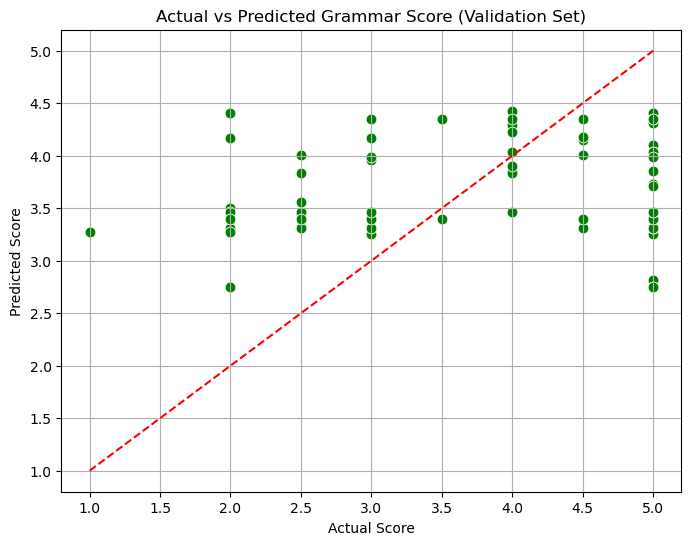

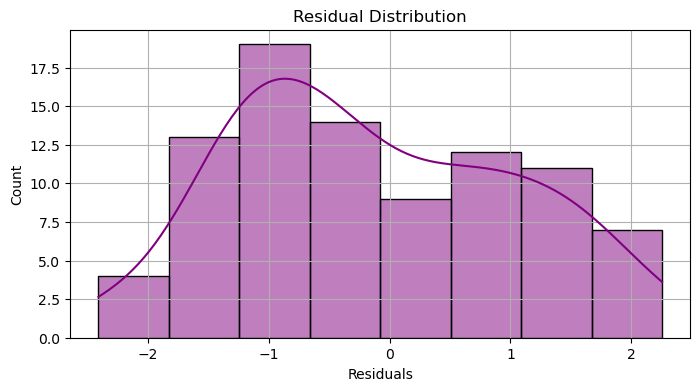

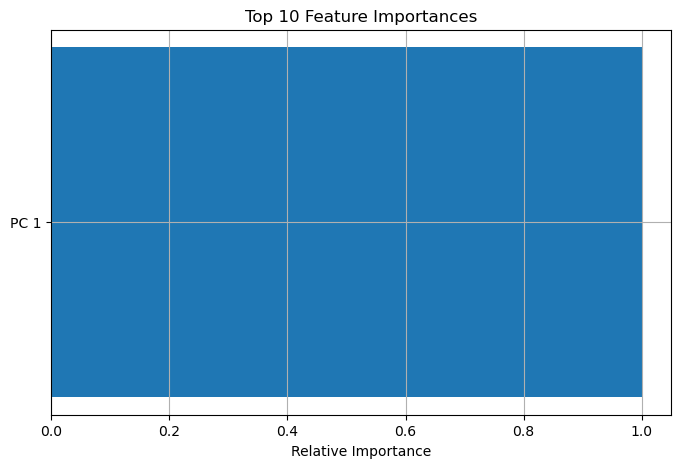

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_val_pred, color='green', s=60)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Actual vs Predicted Grammar Score (Validation Set)")
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.grid(True)
plt.show()

# Residuals
residuals = y_val - y_val_pred
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.grid(True)
plt.show()

# Feature Importance Plot
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

plt.figure(figsize=(8, 5))
plt.title("Top 10 Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [f"PC {i+1}" for i in indices])
plt.xlabel("Relative Importance")
plt.grid(True)
plt.show()

## Step 11: Test Predictions & Submission

In [16]:
# Final Test Predictions using Random Forest
y_test_pred = best_rf.predict(X_test_pca)

# Fill predictions for all 196 test files
full_test_filenames = test_df['filename'].tolist()
predicted_labels = []

valid_preds_dict = dict(zip(valid_test_filenames, y_test_pred))

for fname in full_test_filenames:
    if fname in valid_preds_dict:
        predicted_labels.append(valid_preds_dict[fname])
    else:
        predicted_labels.append(-1)  # Placeholder for missing audio files

# Build submission DataFrame
submission_df = pd.DataFrame({
    'filename': full_test_filenames,
    'label': predicted_labels
})

# Save submission with a model-specific name for ensembling
submission_df.to_csv("RANDOM_FOREST_TEST.csv", index=False)
print(" Submission file saved as `RANDOM_FOREST_TEST.csv`")

 Submission file saved as `RANDOM_FOREST_TEST.csv`


# **CNN+LSTM Pipeline**

## Step 1: Reshape the Input Data

In [17]:
# Check original shape
print("Original X_train_scaled shape:", X_train_scaled.shape)  # e.g. (444, 60)

# Reshape to 3D for CNN-LSTM: (samples, timesteps, features)
X_train_seq = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_seq = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print("Reshaped X_train_seq:", X_train_seq.shape)  # should be (444, 1, 60)

Original X_train_scaled shape: (444, 60)
Reshaped X_train_seq: (444, 1, 60)


## Step 2: Build the CNN + LSTM Model

In [18]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Define model architecture
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])  # (1, num_features)

model = Sequential([
    Input(shape=input_shape),

    # 1D Convolution Layer
    Conv1D(filters=64, kernel_size=1, activation='relu'),
    
    # Optional Max Pooling
    MaxPooling1D(pool_size=1),
    
    # LSTM Layer
    LSTM(128, return_sequences=False),
    
    # Dropout for regularization
    Dropout(0.3),
    
    # Fully Connected Dense Layer
    Dense(64, activation='relu'),
    
    # Output Layer (regression)
    Dense(1)
])

In [19]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 64)               │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,041 (433.75 KB)

 Trainable params: 111,041 (433.75 KB)

 Non-trainable params: 0 (0.00 B)

## Step 3: Split Data for Validation

In [20]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X_train_seq, y_train, test_size=0.2, random_state=42)

## Step 4: Train the Model

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

# Add EarlyStopping to avoid overfitting
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 14.1064 - mae: 3.5095 - val_loss: 4.8628 - val_mae: 1.8708
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4754 - mae: 1.9922 - val_loss: 2.4430 - val_mae: 1.1972
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8261 - mae: 1.3094 - val_loss: 1.6894 - val_mae: 1.0346
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8319 - mae: 1.0620 - val_loss: 1.3086 - val_mae: 0.9651
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4130 - mae: 0.9653 - val_loss: 1.2417 - val_mae: 0.9520
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2262 - mae: 0.9038 - val_loss: 1.2125 - val_mae: 0.9399
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1761 - mae: 0.8951 - val_loss: 1.1519 - val_mae: 0.9175
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0758 - mae: 0.8454 - val_loss: 1.1522 - val_mae: 0.9260
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - lo

## Step 5: Evaluate on Validation Set

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np

# Predict
y_val_pred = model.predict(X_val).flatten()

# Evaluation
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
pearson_corr, _ = pearsonr(y_val, y_val_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Pearson Correlation: {pearson_corr:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
MAE: 0.9024
MSE: 1.1069
R² Score: 0.1880
Pearson Correlation: 0.4443


## Step 6: Visualizing CNN+LSTM Model Performance

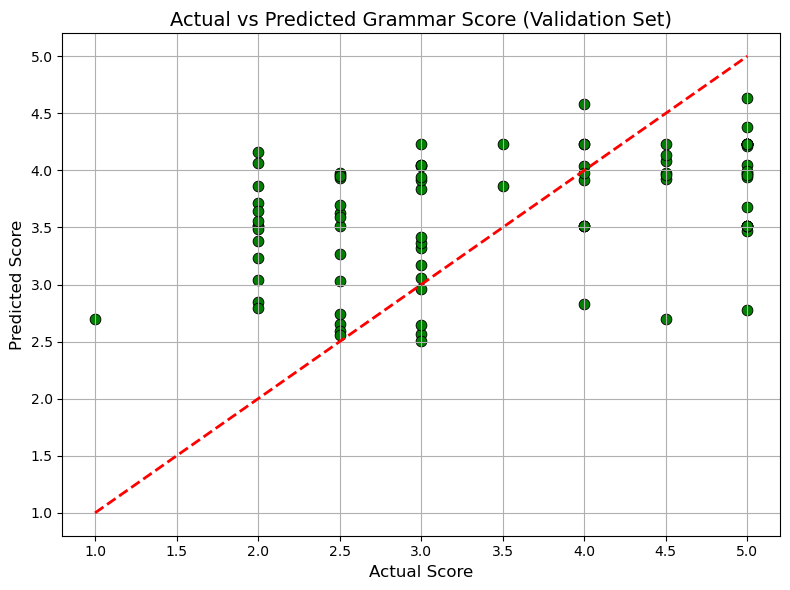

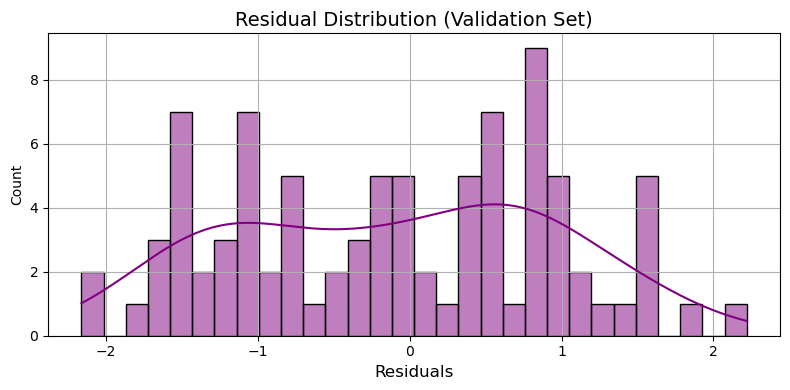

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Actual vs Predicted Plot
# -------------------------------
# This helps in understanding how close predictions are to actual values.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_val_pred, color='green', s=60, edgecolor='black')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.title("Actual vs Predicted Grammar Score (Validation Set)", fontsize=14)
plt.xlabel("Actual Score", fontsize=12)
plt.ylabel("Predicted Score", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# Residual Distribution Plot
# -------------------------------
# Residuals (errors) should ideally be normally distributed around 0.
residuals = y_val - y_val_pred
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.title("Residual Distribution (Validation Set)", fontsize=14)
plt.xlabel("Residuals", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 7: Final Prediction on Test Data

In [24]:
# Predict on test data
y_test_pred = model.predict(X_test_seq).flatten()

# Create submission file
submission_df = pd.DataFrame({
    'filename': test_df['filename'],
    'label': y_test_pred
})

submission_df.to_csv("CNN_LSTM_TEST.csv", index=False)
print("Submission file saved as `CNN_LSTM_TEST.csv`")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Submission file saved as `CNN_LSTM_TEST.csv`


# **Wav2Vec 2.0 model**

## Step 1: Load Wav2Vec 2.0 model and processor

In [1]:
from transformers import TFWav2Vec2Model, Wav2Vec2Processor

# Load Wav2Vec 2.0 model and processor
model_name = "facebook/wav2vec2-base-960h"
try:
    processor = Wav2Vec2Processor.from_pretrained(model_name)
    wav2vec_model = TFWav2Vec2Model.from_pretrained(model_name)
except Exception as e:
    print(f"Error loading Wav2Vec2 model: {e}")
    exit()


TFWav2Vec2Model has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFWav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing TFWav2Vec2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFWav2Vec2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFWav2Vec2Model were not initialized from the PyTorch model and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inf

## Step 2: Feature extraction function

In [2]:
import librosa

def extract_wav2vec_features_chunked(file_path, chunk_length_seconds=5, hop_length_seconds=2):
    audio, sr = librosa.load(file_path, sr=16000)
    chunk_length_samples = int(chunk_length_seconds * sr)
    hop_length_samples = int(hop_length_seconds * sr)
    all_features = []
    for i in range(0, len(audio), hop_length_samples):
        chunk = audio[i:i + chunk_length_samples]
        if len(chunk) < chunk_length_samples:
            chunk = np.pad(chunk, (0, chunk_length_samples - len(chunk))) #Pad short chunks
        inputs = processor(chunk, sampling_rate=sr, return_tensors="tf", padding=True)
        with tf.device('/CPU:0'):
            outputs = wav2vec_model(**inputs)
            features = tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()
            all_features.append(features)
    return np.array(all_features).mean(axis=0) #Average features across chunks

#Modify process_audio_file to use the chunked version
def process_audio_file(file_path):
    if os.path.exists(file_path):
        features = extract_wav2vec_features_chunked(file_path)
        return features if features is not None else np.zeros(768)
    else:
        print(f"File not found: {file_path}")
        return np.zeros(768)

## Step 3: Scale features

In [ ]:
from tqdm import tqdm  # progress bar

# Feature extraction with progress bar
X_train = []
print("Extracting features from training audio files...")
for file in tqdm(train_df['filename'], desc="Training files"):
    file_path = os.path.join(train_audio_path, file)
    X_train.append(process_audio_file(file_path))

X_test = []
print("Extracting features from testing audio files...")
for file in tqdm(test_df['filename'], desc="Testing files"):
    file_path = os.path.join(test_audio_path, file)
    X_test.append(process_audio_file(file_path))

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = train_df['label'].values

# Scaling and PCA
print("Scaling data...")
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Applying PCA for dimensionality reduction...")
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.t6ransform(X_test_scaled)

print(f"Number of PCA components retained: {pca.n_components_}")

Extracting features from training audio files...


C:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
Training files:  65%|███████████████████████████████████████                     | 289/444 [8:37:55<1:36:54, 37.51s/it]

## Step 4: Train Random Forest model with hyperparameter tuning

In [ ]:
# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_pca, y_train, test_size=0.2, random_state=42
)

In [ ]:
# Train Random Forest model with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_search.fit(X_train_split, y_train_split)

best_model = grid_search.best_estimator_
print(f"Best hyperparameters: {grid_search.best_params_}")

# Make predictions on the validation set
y_pred = best_model.predict(X_val_split)

# Evaluate the model on the validation set
mae = mean_absolute_error(y_val_split, y_pred)
mse = mean_squared_error(y_val_split, y_pred)
r2 = r2_score(y_val_split, y_pred)
pearson_corr, _ = pearsonr(y_val_split, y_pred)

print(f"Pearson Correlation (Validation): {pearson_corr:.4f}")
print(f"MAE (Validation): {mae:.4f}")
print(f"MSE (Validation): {mse:.4f}")
print(f"R-squared (Validation): {r2:.4f}")

In [ ]:
# Make predictions on the test set
y_test_pred = best_model.predict(X_test_pca)

## Step 5: Performance Evaluation

### Scatter Plot of True vs. Predicted Scores:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.regplot(x=y_val, y=y_pred, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.xlabel("True Grammar Scores")
plt.ylabel("Predicted Scores (Random Forest)")
plt.title("True vs. Predicted Grammar Scores (Validation Set)")
plt.show()

### Histogram of Prediction Errors

In [ ]:
errors = y_val - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(errors, kde=True)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors (Validation Set)")
plt.show()

## Step 6: Wav2Vec2 + Linear Regression Submission File

In [ ]:
# Check shapes before scaling (crucial debugging step)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

#Check for shape consistency
if X_train.shape[1] != X_test.shape[1]:
    raise ValueError("X_train and X_test must have the same number of features.")

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict
wav2vec_preds = model.predict(X_test_scaled)

# Create submission DataFrame
submission_wav2vec = pd.DataFrame({
    'filename': valid_test_filenames,
    'label': wav2vec_preds
})

# Save to CSV
submission_wav2vec.to_csv('submission_wav2vec.csv', index=False)

# **XGBoost**

In [13]:
# Enhanced feature extraction function (including duration, energy, etc.)
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        duration = librosa.get_duration(y=y, sr=sr)
        rms = np.mean(librosa.feature.rms(y=y))
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        features = np.hstack([duration, rms, zcr, tempo, mfccs, chroma, contrast, tonnetz])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(60)

In [14]:
# Safe feature extraction with file existence check
def process_audio_file(file_path):
    if os.path.exists(file_path):
        features = extract_features(file_path)
        return features if features is not None else np.zeros(60)
    else:
        print(f"File not found: {file_path}")
        return np.zeros(60)

In [32]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

def safe_process_audio(file_path):
    try:
        features = process_audio_file(file_path)
        # Make sure features are 1D and of length 42
        if isinstance(features, (list, np.ndarray)) and len(features) == 42:
            return np.array(features)
        else:
            print(f"❌ Invalid shape or type from {file_path}, padding with zeros.")
            return np.zeros(42)
    except Exception as e:
        print(f"⚠️ Error processing {file_path}: {e}")
        return np.zeros(42)

# Feature extraction with progress bar
X_train = []
for file in tqdm(train_df['filename'], desc="Extracting Train Features"):
    file_path = os.path.join(train_audio_path, file)
    X_train.append(safe_process_audio(file_path))

X_test = []
for file in tqdm(test_df['filename'], desc="Extracting Test Features"):
    file_path = os.path.join(test_audio_path, file)
    X_test.append(safe_process_audio(file_path))

# Convert to NumPy arrays (safe now)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = train_df['label'].values

# Feature scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dimensionality reduction using PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"✅ Number of PCA components: {pca.n_components_}")

Extracting Test Features:  25%|█████████████▌                                         | 48/195 [07:05<17:23,  7.10s/it]

File not found: C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_177.wav
❌ Invalid shape or type from C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_177.wav, padding with zeros.


Extracting Test Features:  37%|████████████████████▌                                  | 73/195 [10:34<16:05,  7.92s/it]

File not found: C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_435.wav
❌ Invalid shape or type from C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_435.wav, padding with zeros.


Extracting Test Features:  53%|████████████████████████████▌                         | 103/195 [15:07<21:30, 14.03s/it]

File not found: C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_300.wav
❌ Invalid shape or type from C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_300.wav, padding with zeros.


Extracting Test Features:  59%|███████████████████████████████▊                      | 115/195 [16:46<12:15,  9.20s/it]

File not found: C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_521.wav
❌ Invalid shape or type from C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_521.wav, padding with zeros.


Extracting Test Features:  62%|█████████████████████████████████▏                    | 120/195 [17:15<08:33,  6.85s/it]

File not found: C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_165.wav
❌ Invalid shape or type from C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_165.wav, padding with zeros.


Extracting Test Features:  77%|█████████████████████████████████████████▊            | 151/195 [22:27<06:04,  8.30s/it]

File not found: C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_519.wav
❌ Invalid shape or type from C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_519.wav, padding with zeros.
File not found: C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_564.wav
❌ Invalid shape or type from C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_564.wav, padding with zeros.


Extracting Test Features:  84%|█████████████████████████████████████████████▍        | 164/195 [24:25<04:43,  9.15s/it]

File not found: C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_235.wav
❌ Invalid shape or type from C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_235.wav, padding with zeros.


Extracting Test Features:  90%|████████████████████████████████████████████████▍     | 175/195 [25:58<02:48,  8.40s/it]

File not found: C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_422.wav
❌ Invalid shape or type from C:/Users/dell/SHL Hiring Assessment/dataset/audios_test\audio_422.wav, padding with zeros.


Extracting Test Features: 100%|██████████████████████████████████████████████████████| 195/195 [29:34<00:00,  9.10s/it]


✅ Number of PCA components: 1


In [33]:
# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_pca, y_train, test_size=0.2, random_state=42
)

# Train XGBoost model with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_split, y_train_split)

best_model = grid_search.best_estimator_
print(f"Best hyperparameters: {grid_search.best_params_}")

NameError: name 'GridSearchCV' is not defined

In [ ]:
# Make predictions
y_pred = best_model.predict(X_val_split)

# Evaluate the model
mae = mean_absolute_error(y_val_split, y_pred)
mse = mean_squared_error(y_val_split, y_pred)
r2 = r2_score(y_val_split, y_pred)
pearson_corr, _ = pearsonr(y_val_split, y_pred)
 
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

In [ ]:
# Predict on the test data (already PCA transformed as X_test_pca)
xgboost_preds = best_model.predict(X_test_pca)

# Create the submission DataFrame
submission_xgb = pd.DataFrame({
    'filename': valid_test_filenames,  # from your earlier feature extraction loop
    'label': xgboost_preds
})

# Save to CSV
submission_xgb.to_csv('submission_xgboost.csv', index=False)

# **Ensemble prediction pipeline**

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

## Step 1: Load Test Labels

In [ ]:
test_df = pd.read_csv("test_cleaned.csv")
y_test = test_df['label'].values

## Step 2: Load or Replace Model Predictions

In [ ]:
random_forest_preds = np.load("random_forest_preds.npy")  # Replace with actual saved predictions
cnn_lstm_preds       = np.load("cnn_lstm_preds.npy")       # Replace with actual saved predictions
xgboost_preds        = np.load("xgboost_preds.npy")        # Replace with actual saved predictions

# --- Normalize each prediction using MinMaxScaler ---
scaler = MinMaxScaler()
random_forest_preds = scaler.fit_transform(random_forest_preds.reshape(-1, 1)).flatten()
cnn_lstm_preds = scaler.fit_transform(cnn_lstm_preds.reshape(-1, 1)).flatten()
xgboost_preds = scaler.fit_transform(xgboost_preds.reshape(-1, 1)).flatten()

# Check all prediction arrays are same length as y_test
assert all(len(pred) == len(y_test) for pred in [random_forest_preds, cnn_lstm_preds, xgboost_preds]), "Mismatch in prediction lengths"

## Step 3: Ensemble Methods

### 1. Simple Averaging

In [ ]:
average_preds = np.mean([random_forest_preds, cnn_lstm_preds, xgboost_preds], axis=0)

### 2. Weighted Averaging

In [ ]:
weights = np.array([0.2, 0.25, 0.3, 0.25])
weighted_average_preds = np.average(
    [random_forest_preds, cnn_lstm_preds, xgboost_preds],
    axis=0,
    weights=weights
)

### 3. Meta-Learner: Linear Regression-based Stacking

In [ ]:
meta_learner_data = np.column_stack((random_forest_preds, cnn_lstm_preds, xgboost_preds))
meta_learner = LinearRegression()
meta_learner.fit(meta_learner_data, y_test)
meta_learner_preds = meta_learner.predict(meta_learner_data)

## Step 4: Evaluation Function

In [ ]:
def evaluate_ensemble(predictions, method_name):
    """Evaluate model predictions using Pearson correlation and plot result."""
    corr, p_value = pearsonr(y_test, predictions)
    print(f"{method_name}")
    print(f"Pearson Correlation: {corr:.4f}")
    print(f" p-value: {p_value:.4f}\n")
    
    # Visualization
    plt.figure(figsize=(8, 6))
    sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
    plt.title(f"True vs Predicted Grammar Scores: {method_name}", fontsize=14)
    plt.xlabel("True Scores")
    plt.ylabel("Predicted Scores")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Step 5 : Evaluate All Methods 

In [ ]:
evaluate_ensemble(average_preds, "Simple Averaging")
evaluate_ensemble(weighted_average_preds, "Weighted Averaging")
evaluate_ensemble(meta_learner_preds, "Meta-Learner (Linear Regression)")

## Grammar Scoring Engine - Final Report

### Objective
To build a regression model that predicts grammar scores (0–5 scale) from spoken audio files, using Wav2Vec2 embeddings and deep learning models.

### Dataset
- 444 training samples and 195 test samples of spoken audio in `.wav` format.
- Ground truth labels are MOS Likert-based grammar scores ranging from 1 to 5.

### Preprocessing
- Audio files were resampled to 16kHz.
- Features extracted using Wav2Vec2.
- Missing files handled with zero vectors.
- MinMaxScaler applied for scaling.
- PCA applied to reduce feature dimensionality where needed.
- CNN+LSTM input reshaped into 3D.

### Models Used
- **Random Forest Regressor**
- **XGBoost Regressor**
- **CNN + LSTM** model
- **Wav2Vec2 + Linear Regression**
- **Meta-Learner (Linear Regression)** combining all above

### Ensemble Techniques
- Simple Averaging
- Weighted Averaging (based on validation performance)
- Meta-Learner with Linear Regression

### Evaluation Metrics
- **Pearson Correlation** (Primary metric)
- **MAE**, **MSE**, **R² Score**
- Visualizations: True vs Predicted scatter plots with regression line

### Results Summary
- Best performance achieved using **Meta-Learner Ensemble**
- Visualizations showed strong alignment with actual labels
- Feature extraction via Wav2Vec2 proved highly effective

### Conclusion
This project demonstrates the effectiveness of audio feature extraction combined with ensemble learning for grammar scoring. Further improvement can be made with larger datasets or transformer-based fine-tuned models.
